## Bretthorst-Jaynes Analysis

In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.stats import skewnorm, norm

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [2]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if zero_padding:
        a = np.insert(a, np.zeros(n-1,dtype=int), np.zeros(n-1), axis=-1)
        a = np.roll(a, -int((n-1)/2), axis=-1)
    if const_padding:
        l1 = int(n/2)
        if n%2 != 1: # n is even
            l2 = l1-1
        else: # n is odd
            l2 = l1
            ind2 = -np.arange(1,(n+1)/2).astype(int)
        a = np.insert(a, np.zeros(l1, dtype=int), np.ones(l1)*a[0])
        a = np.insert(a, -np.ones(l2, dtype=int), np.ones(l2)*a[-1])
    ret = np.cumsum(a, dtype=float, axis=-1)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
#Returns binning needed to resolve a frequency.
def get_binning(sim, dt, frequency=80*u.Hz): 
    duration = sim.time[-1]-sim.time[0]
    samples = (duration/dt.to(u.s)).value
    return int((1/frequency*samples/duration).value) #binning needed to filter out sinals with f>f_lb_sasi

In [4]:
# Binning of the moving average filter defined by the Nyquist frequency of the SASI modulation
# If the sampling was to be finer the binning could be done finer, however this comes at the expense of lower
# statistics. Therefore we keep the sampling rate at 1 ms.

def get_average_signal(sim, dt, distance, frequency=80*u.Hz):
    binning = get_binning(sim, dt, frequency)

    #detector_signal s0 is not drawn from distribution
    t, s0_i3 = sim.detector_signal(dt=dt, subdetector='i3')
    t, s0_dc = sim.detector_signal(dt=dt, subdetector='dc')
    t, s0_md = sim.detector_signal(dt=dt, subdetector='md')

    s0_ic86 = s0_i3 + s0_dc
    s0_gen2 = s0_i3 + s0_dc + s0_md
    t = t.to(u.ms)

    #averaged signal sa binning size defined by the Nyquist frequency of the SASI modulation and constant padding
    sa_ic86 = moving_average(s0_ic86, n=binning, const_padding=True)
    sa_gen2 = moving_average(s0_gen2, n=binning, const_padding=True)
    
    return sa_gen2, sa_ic86

In [5]:
def signal_processing(sim, dt, distance, trials, dist = skewnorm, sig_method='pdf_median', 
                      residual=True, smoothing=False,
                      return_raw=False,
                      return_percentage=False,
                      return_fourier=False, 
                      return_power=False, 
                      return_bretthorst_jaynes = False,
                      return_pfbj=False,
                      return_max_power=False,
                      return_test_statistics=False,
                      return_significance=False):

    # scale simulation with distance
    sim.scale_result(distance=distance)
    
    sa_gen2, sa_ic86 = get_average_signal(sim, dt=dt, distance=distance)
    
    # time and signal realization for each detector component
    t, s_i3 = sim.detector_hits(dt=dt, subdetector='i3', size=trials)
    t, s_dc = sim.detector_hits(dt=dt, subdetector='dc', size=trials)
    t, s_md = sim.detector_hits(dt=dt, subdetector='md', size=trials)
    #t, s_ws = sim.detector_hits(dt=dt, subdetector='ws')
    t = t.to(u.ms)

    # random background realization
    b_i3 = sim.detector.i3_bg(dt=dt, size=s_i3.shape[1]*trials)
    b_dc = sim.detector.dc_bg(dt=dt, size=s_dc.shape[1]*trials)
    b_md = sim.detector.md_bg(dt=dt, size=s_md.shape[1]*trials)
    #b_ws = sim.detector.ws_bg(dt=dt, size=len(s_ws)*trials)
    
    # reshape background
    b_i3 = b_i3.reshape(trials,s_i3.shape[1])
    b_dc = b_dc.reshape(trials,s_dc.shape[1])
    b_md = b_md.reshape(trials,s_md.shape[1])

    s_ic86 = s_i3 + s_dc
    s_gen2 = s_i3 + s_dc + s_md
    b_ic86 = b_i3 + b_dc
    b_gen2 = b_i3 + b_dc + b_md
  
    # combined signal hypo: signal + background
    S_ic86 = s_ic86 + b_ic86
    S_gen2 = s_gen2 + b_gen2
    # combined background hypo: average signal + background
    B_ic86 = sa_ic86 + b_ic86
    B_gen2 = sa_gen2 + b_gen2
    
    # background subtraction: signal + background - average background
    Sb_ic86 = S_ic86 - ba_ic86
    Sb_gen2 = S_gen2 - ba_gen2
    Bb_ic86 = B_ic86 - ba_ic86
    Bb_gen2 = B_gen2 - ba_gen2

    # percentage deviation Spd: (signal + background - average background)/average signal
    Spd_ic86 = (Sb_ic86/sa_ic86)-1
    Spd_gen2 = (Sb_gen2/sa_gen2)-1
    Bpd_ic86 = (Bb_ic86/sa_ic86)-1
    Bpd_gen2 = (Bb_gen2/sa_gen2)-1
    
    if smoothing == True:
        smoothing_bins = get_binning(sim, dt, frequency=500*u.Hz)
        Spd_ic86 = moving_average(Spd_ic86, n=smoothing_bins, const_padding=True)
        Spd_gen2 = moving_average(Spd_gen2, n=smoothing_bins, const_padding=True)
        Bpd_ic86 = moving_average(Bpd_ic86, n=smoothing_bins, const_padding=True)
        Bpd_gen2 = moving_average(Bpd_gen2, n=smoothing_bins, const_padding=True)

    # variance of percentage deviation
    if residual:
        Bvar_ic86 = np.var(Bpd_ic86)
        Bvar_gen2 = np.var(Bpd_gen2)
    else:
        Bvar_ic86 = ba_ic86
        Bvar_gen2 = ba_gen2
    
    t_mask = np.logical_and(t>=time_wind[0], t<=time_wind[1])    
    tf = t[t_mask]
    N = len(tf)
    T = sim._res_dt.value
    
    #Fourier transformation of the percentage variation
    if residual:  
        Sfu_ic86 = 2.0/N * np.abs(fft(Spd_ic86[:,t_mask], axis = -1)[:,1:N//2])
        Sfu_gen2 = 2.0/N * np.abs(fft(Spd_gen2[:,t_mask], axis = -1)[:,1:N//2])
        Bfu_ic86 = 2.0/N * np.abs(fft(Bpd_ic86[:,t_mask], axis = -1)[:,1:N//2])
        Bfu_gen2 = 2.0/N * np.abs(fft(Bpd_gen2[:,t_mask], axis = -1)[:,1:N//2])      
    else:
        Sfu_ic86 = 2.0/N * np.abs(fft(S_ic86[:,t_mask], axis = -1)[:,1:N//2])
        Sfu_gen2 = 2.0/N * np.abs(fft(S_gen2[:,t_mask], axis = -1)[:,1:N//2])
        Bfu_ic86 = 2.0/N * np.abs(fft(B_ic86[:,t_mask], axis = -1)[:,1:N//2])
        Bfu_gen2 = 2.0/N * np.abs(fft(B_gen2[:,t_mask], axis = -1)[:,1:N//2])
  
    f = fftfreq(N,T)[1:N//2]
    f_mask = np.logical_and(f>=freq_wind[0].value, f<=freq_wind[1].value)

    #Power spectrum
    Sp_ic86 = Sfu_ic86**2
    Sp_gen2 = Sfu_gen2**2
    Bp_ic86 = Bfu_ic86**2
    Bp_gen2 = Bfu_gen2**2
    
    #Bretthorst-Jaynes
    Sbj_ic86 = np.exp(Sp_ic86[:,f_mask]/Bvar_ic86)
    Sbj_gen2 = np.exp(Sp_gen2[:,f_mask]/Bvar_gen2)
    Bbj_ic86 = np.exp(Bp_ic86[:,f_mask]/Bvar_ic86)
    Bbj_gen2 = np.exp(Bp_gen2[:,f_mask]/Bvar_gen2)

    # maximum Bretthorst-Janes ~ posterior prob
    Sm_ic86 = np.max(Sbj_ic86, axis=-1)
    Sm_gen2 = np.max(Sbj_gen2, axis=-1)
    Bm_ic86 = np.max(Bbj_ic86, axis=-1)
    Bm_gen2 = np.max(Bbj_gen2, axis=-1)    
      
    # background fit parameters
    Bfp_ic86 = dist.fit(Bm_ic86)
    Bfp_gen2 = dist.fit(Bm_gen2)

    # fitted background distribution
    Bf_ic86 = dist(*Bfp_ic86)
    Bf_gen2 = dist(*Bfp_gen2)
    
    # median, 16% and 84% quantiles of TS distribution
    Sts_gen2 = np.array([np.median(Sm_gen2), np.quantile(Sm_gen2, 0.16), np.quantile(Sm_gen2, 0.84)])
    Sts_ic86 = np.array([np.median(Sm_ic86), np.quantile(Sm_ic86, 0.16), np.quantile(Sm_ic86, 0.84)])
    Bts_gen2 = np.array([np.median(Bm_gen2), np.quantile(Bm_gen2, 0.16), np.quantile(Bm_gen2, 0.84)])
    Bts_ic86 = np.array([np.median(Bm_ic86), np.quantile(Bm_ic86, 0.16), np.quantile(Bm_ic86, 0.84)])

    ### SIGNIFICANCE ###
    if sig_method == 'weighted_difference':
    # Defined as difference between the mean of the signal and background distribution devided by the square root
    # of the sum of the variance of the two distributions
        Z_ic86 = np.abs(Sm_ic86.mean()-Bm_ic86.mean())/np.sqrt(Sm_ic86.std()**2+Bm_ic86.std()**2)
        Z_gen2 = np.abs(Sm_gen2.mean()-Bm_gen2.mean())/np.sqrt(Sm_gen2.std()**2+Bm_gen2.std()**2)
    elif sig_method == 'pdf_median':
    # take the median and quantiles of the signal trials and compute the corresponding p-value/significance 
    # from the bkg distribution
        Z_ic86 = []
        Z_gen2 = []
        for i in range(3):  # loop over Sts values (median, 16%, 84% quantiles)   
        # p-value of signal given a background distribution

            p_ic86 = Bf_ic86.sf(Sts_ic86[i])
            p_gen2 = Bf_gen2.sf(Sts_gen2[i])
            
            # two-sided Z score corresponding to the respective p-value, survival probability = 1 - cdf
            z_ic86 = norm.isf(p_ic86/2)
            z_gen2 = norm.isf(p_gen2/2)
            
            Z_ic86.append(z_ic86)
            Z_gen2.append(z_gen2)
    
    if return_raw:
        return t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86
    
    if return_percentage:
        return t, Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86
    
    if return_fourier:
        return f, Sfu_gen2, Sfu_ic86, Bfu_gen2, Bfu_ic86
    
    if return_power:
        return f, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86
    
    if return_bretthorst_jaynes:
        return f, Sbj_gen2, Sbj_ic86, Bbj_gen2, Bbj_ic86 
    
    if return_pfbj:
        r = [S_gen2, S_ic86, B_gen2, B_ic86]
        pd = [Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86]
        p = [Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86]
        bj = [Sbj_gen2, Sbj_ic86, Bbj_gen2, Bbj_ic86]
        return t, f, r, pd, p, bj 
    
    if return_max_power:
        return f, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Bf_gen2, Bf_ic86
    
    if return_test_statistics:
        return Sts_gen2, Sts_ic86, Bts_gen2, Bts_ic86
    
    if return_significance:
        return Sts_gen2, Sts_ic86, Bts_gen2, Bts_ic86, Z_gen2, Z_ic86

In [13]:
dt = 1 * u.ms

include_wls = False #"False", "True"

stime = "indep" # "dep", "indep"
sfreq = "indep" # "dep", "indep"

smix = "NoTransformation" # "NoTransformation", "CompleteExchange", "AdiabaticMSW"
shier = "normal" # "normal", "inverted"
smodel = "Tamborra_2014_20M" # "Tamborra_2014_20M", "Tamborra_2014_27M"
sdir = 3

if smodel == "Tamborra_2014_11M":
    #Does not show SASI, maybe LESA
    Emin, Emax, dE = 0*u.MeV, 100*u.MeV, 1*u.MeV
    tmin, tmax, dt = 0.010*u.s, 0.34979*u.s, dt
    mass = 11.2*u.Msun
    sdir = 1
    
elif smodel == "Tamborra_2014_20M":
    Emin, Emax, dE = 0*u.MeV, 100*u.MeV, 1*u.MeV
    tmin, tmax, dt = 0.006*u.s, 0.338*u.s, dt
    mass = 20*u.Msun
    sdir = 1
    
elif smodel == "Tamborra_2014_27M":
    Emin, Emax, dE = 0*u.MeV, 100*u.MeV, 1*u.MeV
    tmin, tmax, dt = 0.011*u.s, 0.552*u.s, dt
    mass = 27*u.Msun

else:
    raise ValueError('Model '+smodel+' does not exist!')
    
if sfreq == "dep":
    freq_wind = [75, 85] * u.Hz # formerly 125 Hz, now +-5 Hz
    
elif sfreq == "indep":
    freq_wind = [75, 1E6] * u.Hz 

if stime == "dep":
        time_wind = [0.150, 0.300] * u.s
        
elif stime == "indep":
        time_wind = [0, 1] * u.s
        
model = {'name': 'Tamborra_2014',
             'param':{
             'progenitor_mass': mass,
             'direction': sdir}
            }

sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=Emin, Emax=Emax, dE=dE,
                 tmin=tmin, tmax=tmax, dt=dt,
                 hierarchy = shier,
                 mixing_scheme = smix,
                 geomscope = 'Gen2',
                 include_wls = include_wls)
sim.run()

In [14]:
print(smodel, sdir)
print(smix)
print(shier)
print(time_wind)
print(freq_wind)
print('WLS ?: {}'.format(include_wls))

Tamborra_2014_20M 1
NoTransformation
normal
[0. 1.] s
[7.5e+01 1.0e+06] Hz
WLS ?: False


In [15]:
#average background given by the mean of the sensor distribution and scaled to the full detector
ba_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
ba_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)

In [16]:
distances = np.arange(1,41,1) * u.kpc
trials = 10000
Sts_gen2, Sts_ic86, Bts_gen2, Bts_ic86, Z_gen2, Z_ic86 = [], [], [], [], [], []
for d in distances:
    print('distance {:.0f}'.format(d))
    sts_gen2, sts_ic86, bts_gen2, bts_ic86, z_gen2, z_ic86 =  signal_processing(sim, dt=dt, distance=d, trials=trials, return_significance=True)
    
    Sts_gen2.append(sts_gen2)
    Sts_ic86.append(sts_ic86)
    Bts_gen2.append(bts_gen2)
    Bts_ic86.append(bts_ic86)
    Z_gen2.append(z_gen2)
    Z_ic86.append(z_ic86)
    
Sts_gen2 = np.array(Sts_gen2)
Sts_ic86 = np.array(Sts_ic86)
Bts_gen2 = np.array(Bts_gen2)
Bts_ic86 = np.array(Bts_ic86)
Z_gen2 = np.array(Z_gen2)
Z_ic86 = np.array(Z_ic86)

distance 1 kpc
distance 2 kpc
distance 3 kpc
distance 4 kpc
distance 5 kpc
distance 6 kpc
distance 7 kpc
distance 8 kpc
distance 9 kpc
distance 10 kpc
distance 11 kpc
distance 12 kpc
distance 13 kpc
distance 14 kpc
distance 15 kpc
distance 16 kpc
distance 17 kpc
distance 18 kpc
distance 19 kpc
distance 20 kpc
distance 21 kpc
distance 22 kpc
distance 23 kpc
distance 24 kpc
distance 25 kpc
distance 26 kpc
distance 27 kpc
distance 28 kpc
distance 29 kpc
distance 30 kpc
distance 31 kpc
distance 32 kpc
distance 33 kpc
distance 34 kpc
distance 35 kpc
distance 36 kpc
distance 37 kpc
distance 38 kpc
distance 39 kpc
distance 40 kpc


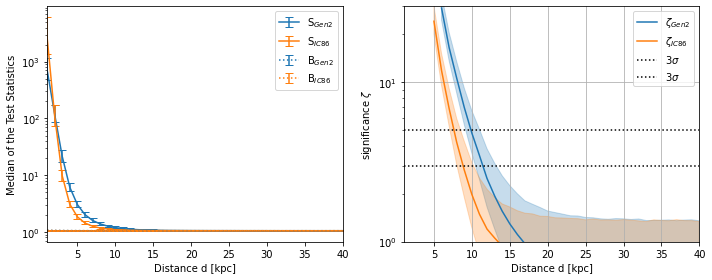

In [17]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

ax[0].errorbar(x=distances, y=Sts_gen2.T[0],yerr=(Sts_gen2.T[0]-Sts_gen2.T[1],Sts_gen2.T[2]-Sts_gen2.T[0]), capsize=4, color = 'C0', label=r'S$_{Gen2}$')
ax[0].errorbar(x=distances, y=Sts_ic86.T[0],yerr=(Sts_ic86.T[0]-Sts_ic86.T[1],Sts_ic86.T[2]-Sts_ic86.T[0]), capsize=4, color = 'C1', label=r'S$_{IC86}$')
ax[0].errorbar(x=distances, y=Bts_gen2.T[0],yerr=(Bts_gen2.T[0]-Bts_gen2.T[1],Bts_gen2.T[2]-Bts_gen2.T[0]), capsize=4, color = 'C0', ls = ':', label=r'B$_{Gen2}$')
ax[0].errorbar(x=distances, y=Bts_ic86.T[0],yerr=(Bts_ic86.T[0]-Bts_ic86.T[1],Bts_ic86.T[2]-Bts_ic86.T[0]), capsize=4, color = 'C1', ls = ':', label=r'B$_{IC86}$')
ax[0].set_xlabel('Distance d [kpc]')
ax[0].set_ylabel('Median of the Test Statistics'.format(freq_wind[0]))
ax[0].set_xlim((1,40))
ax[0].set_yscale('log')
ax[0].legend()

ax[1].plot(distances, Z_gen2.T[0], color = 'C0', label=r'$\zeta_{Gen2}$')
ax[1].plot(distances, Z_ic86.T[0], color = 'C1', label=r'$\zeta_{IC86}$')
ax[1].fill_between(distances.value, Z_gen2.T[2], Z_gen2.T[1], alpha = 0.25, color = 'C0')
ax[1].fill_between(distances.value, Z_ic86.T[2], Z_ic86.T[1], alpha = 0.25, color = 'C1')

ax[1].axhline(3, color='k', ls = ':', label = '3$\sigma$')
ax[1].axhline(5, color='k', ls = ':', label = '3$\sigma$')
ax[1].set_xlabel('Distance d [kpc]')
ax[1].set_ylabel('significance $\zeta$')
ax[1].set_xlim((1,40))
ax[1].set_ylim((1,30))
#ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend()

plt.tight_layout()

In [19]:
import pickle
data = [distances, Sts_gen2, Sts_ic86, Bts_gen2, Bts_ic86, Z_gen2, Z_ic86]
if include_wls:
    filename = './files/bj_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq'+sfreq+'_IC86+Gen2+WLS.pkl'
else:
    filename = './files/bj_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq'+sfreq+'_IC86+Gen2.pkl'
    
file = open(filename, 'wb')
pickle.dump(data,file)